# **Avance 1. Análisis exporatorio de datos**

---

Profa. Dra. Grettel Barceló Alonso 

Prof. Dr. Luis Eduardo Falcón Morales 

Profa. Verónica Sandra Guzmán de Valle 

---


**Estudiantes:**


Marcela Alejandra Rosales Jiménez – A01032022

José Antonio Mendoza Castro – A01794067


29 de septiembre de 2024



## WTS

### **Videos**

Importar librerias

In [113]:
import cv2
import pathlib

import seaborn as sns
import pandas as pd

Visualizar cuantos archivos en el directorio `wts_dataset_zip`. Antes de correr el siguiente codigo se verifico que ya se hubieran extraido los 4 archivos zip que estaban dentro del dataset.

In [45]:
dataset_path = f"dataset/wts_dataset_zip"

In [46]:
def get_all_files(files_path):
    files_path = pathlib.Path(files_path)
    listed_elements = list(files_path.rglob("*"))                           
    listed_files = [e for e in listed_elements if not e.is_dir()]
    return listed_files

def get_listed_files_with_types(listed_files):
  files_types = {}
  for ff in listed_files:
    ext = ff.suffix
    if not files_types.get(ext):
      files_types[ext] = []
    files_types[ext].append(str(ff))
  return files_types



listed_files = get_all_files(f"{dataset_path}")
print(f"Cantidad de archivos en total = {len(listed_files)}")


files_by_ext = get_listed_files_with_types(listed_files)

for k, v in files_by_ext.items():
    print(f" - Extension {k} tiene {len(v)}")


Cantidad de archivos en total = 14126
 - Extension .csv tiene 1
 - Extension .zip tiene 4
 - Extension  tiene 1
 - Extension .DS_Store tiene 1
 - Extension .json tiene 9907
 - Extension .mp4 tiene 4212


Podemos ver que dentro de el zip del dataset hay 4,212 videos.

Visualmente se evaluan los videos y se decide lo siguiente
- No se utilizarán los videos que estan dentro de `wts_dataset_zip/external` ya que son grabaciones desde la perspectiva del asiento delantero de un carro.
- No se utilizarán los videos que estén dentro de una carpeta llamada `vehicle_view` por el mismo motivo.

In [87]:
files_overhead_view = []
files_overhead_view_by_type = {
    'train': [],
    'val': [],
}

for mp4 in files_by_ext['.mp4']:
    if not f"{dataset_path}/external" in mp4 and not "vehicle_view" in  mp4:
        files_overhead_view.append(mp4)
        if "videos/train" in mp4:
            files_overhead_view_by_type['train'].append(mp4)
        elif "videos/val" in mp4:
            files_overhead_view_by_type['val'].append(mp4)
        else:
            print(f"W: No train ni val. Que es? {mp4}")
            

print(f"Cantidad de archivos a utilizar = {len(files_overhead_view)}")
for k, v in files_overhead_view_by_type.items():
    print(f" - {k} tiene {len(v)}")


Cantidad de archivos a utilizar = 600
 - train tiene 403
 - val tiene 197


Podemos concluir que para los objetivos de nuestro proyecto tenemos 600 videos mp4, de los cuales el dataset de WTS sugiere usar 403 en videos de entrenamiento y 197 en videos de validación.

Sobre los videos podemos ver que todos tienen un valor de 30 frames per second, 1920 width y 1080 height.

In [138]:
overhead_view_num_frames = {}

for ff in files_overhead_view:
    cap = cv2.VideoCapture(ff)
    overhead_view_num_frames[ff] = [int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FPS))]

df = pd.DataFrame.from_dict(overhead_view_num_frames, orient='index', columns=['num_frames', 'frame_width', 'frame_height', 'fps'])
df.head()

,num_frames,frame_width,frame_height,fps
dataset/wts_dataset_zip/videos/train/20231006_15_CN28_T1/overhead_view/20231006_15_CN28_T1_192.168.0.13_4.mp4,2279,1920,1080,30
dataset/wts_dataset_zip/videos/train/20231006_15_CN28_T1/overhead_view/20231006_15_CN28_T1_192.168.0.28_2.mp4,2279,1920,1080,30
dataset/wts_dataset_zip/videos/train/20231006_15_CN28_T1/overhead_view/20231006_15_CN28_T1_192.168.0.12_3.mp4,2279,1920,1080,30
dataset/wts_dataset_zip/videos/train/20231006_15_CN28_T1/overhead_view/20231006_15_CN28_T1_192.168.0.11_1.mp4,2279,1920,1080,30
dataset/wts_dataset_zip/videos/train/20230929_61_CN35_T1/overhead_view/20230929_61_CN35_T1_192.168.0.13_4.mp4,2210,1920,1080,30


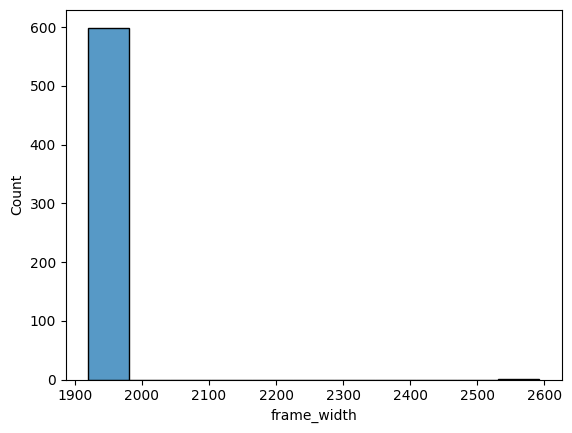

In [137]:
sns.histplot(data=df, x="frame_width");

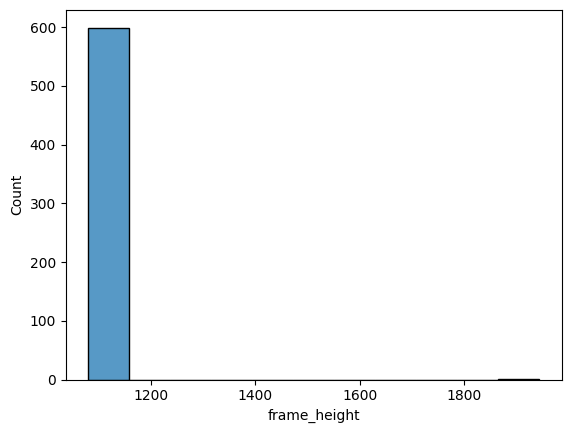

In [135]:
sns.histplot(data=df, x="frame_height");

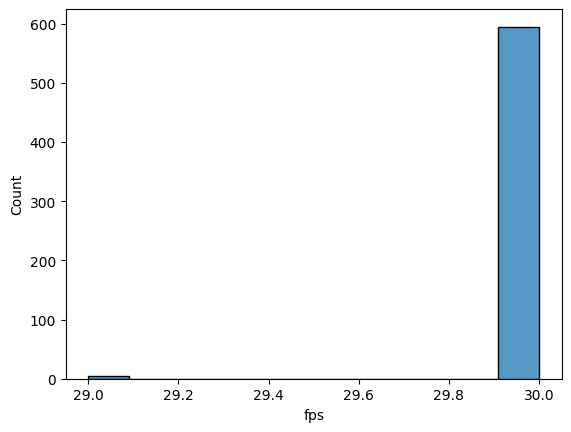

In [136]:
sns.histplot(data=df, x="fps");

También la mayoría de los videos tienen entre 1500 y 3000 frames per second, y hay algunos outliers cerca de 8000 fps.

Esta información nos indica que es posible que tengamos que reducir el número de frames necesarios para nuestro proyecto, mientras podamos mantener suficiente información de las 5 fases de comportamiento de peatón.
1. pre-reconocimiento
2. reconocimiento
3. juicio
4. acción
5. evasión

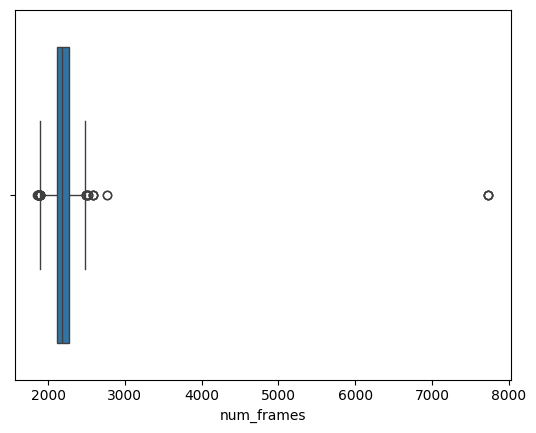

In [143]:
sns.boxplot(data=df, x="num_frames");

### **Anotaciones**

A continuación se muestra un ejemplo de cómo son las anotacionse en formato JSON que tiene el dataset para los videos. Se ve que viene información sobre el video al que correspone en la llave `overhead_videos`, la información que describe la situación de las distintas fases de comportamiento del peatón así como el tiempo en que empieza y termina la fase.

In [144]:
files_overhead_view_by_type['train'][0]

'dataset/wts_dataset_zip/videos/train/20231006_15_CN28_T1/overhead_view/20231006_15_CN28_T1_192.168.0.13_4.mp4'

In [145]:
! cat dataset/wts_dataset_zip/annotations/caption/train/20231006_15_CN28_T1/overhead_view/20231006_15_CN28_T1_caption.json

{
    "id": 1720,
    "overhead_videos": [
        "20231006_15_CN28_T1_192.168.0.11_1.mp4",
        "20231006_15_CN28_T1_192.168.0.12_3.mp4",
        "20231006_15_CN28_T1_192.168.0.13_4.mp4",
        "20231006_15_CN28_T1_192.168.0.28_2.mp4"
    ],
    "event_phase": [
        {
            "labels": [
                "4"
            ],
            "caption_pedestrian": "The pedestrian is a male in his 30s with a height of 170 cm. He is wearing a black T-shirt and black slacks. It is a clear and bright day with the road surface being dry and level. The pedestrian is walking in front of the vehicle, in the opposite direction, and on the left side. He is relatively close to the vehicle. The pedestrian notices the vehicle approaching and traveling on a residential road with two-way traffic. The pedestrian is slowly walking in a car lane. There is no sidewalk on either side, and the roadside strip is also absent. The pedestrian's general action is a collision. Overall, the pedestrian is in